<a href="https://colab.research.google.com/github/dapoarr/Materi-Mechine-Learning/blob/main/Copy_of_Demo_ILT_5_Riding_the_wave_of_NLP_Experience_%5BLSTM%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Processing

This tutorial demonstrates text classification on a dataset of bbc-text.


## Import TensorFlow

In [ ]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt


# bbc-text.csv
!gdown --id 1rX10xeI3eUJmOLsc4pOPY6AnCLO8DxNj

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1rX10xeI3eUJmOLsc4pOPY6AnCLO8DxNj
To: /content/bbc-text.csv
100% 5.06M/5.06M [00:00<00:00, 153MB/s]


## Prepare the dataset for training

In [ ]:
vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .8

In [ ]:
sentences = []
labels = []
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

In [ ]:
with open("./bbc-text.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        labels.append(row[0])
        sentence = row[1]
        for word in stopwords:
            token = " " + word + " "
            sentence = sentence.replace(token, " ")
        sentences.append(sentence)

In [ ]:
train_size = int(len(sentences) * training_portion)

train_sentences = sentences[:train_size]
train_labels = labels[:train_size]

validation_sentences = sentences[train_size:]
validation_labels = labels[train_size:]

In [ ]:

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

In [ ]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

## Create the model

In [ ]:
def create_model(vocab_size, embedding_dim, max_length):
  model = models.Sequential([
  layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
  layers.LSTM(24),
  # layers.Dense(24, activation='relu'),
  layers.Dense(6, activation='softmax')
  ])

  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=optimizers.Adam(),
                metrics=['accuracy'])

  return model

In [ ]:
model = create_model(vocab_size, embedding_dim, max_length)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Train & evaluate the model

In [ ]:
num_epochs = 30
history = model.fit(train_padded, training_label_seq,
                    epochs=num_epochs,
                    validation_data=(validation_padded, validation_label_seq))

Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.2312 - loss: 1.7516 - val_accuracy: 0.2787 - val_loss: 1.5990
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2705 - loss: 1.5864 - val_accuracy: 0.3056 - val_loss: 1.5456
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3596 - loss: 1.4875 - val_accuracy: 0.4427 - val_loss: 1.3272
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4431 - loss: 1.2874 - val_accuracy: 0.3798 - val_loss: 1.5124
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3807 - loss: 1.4227 - val_accuracy: 0.4989 - val_loss: 1.2824
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3903 - loss: 1.4170 - val_accuracy: 0.4584 - val_loss: 1.2752
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5228 - loss: 1.1482 - val_accuracy: 0.5371 - val_loss: 1.1338
Epoch 8/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5860 - loss: 1.0557 - val_accuracy: 0.5438 - val_lo

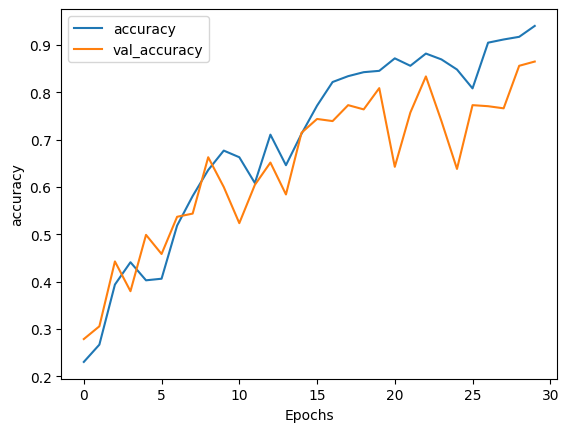

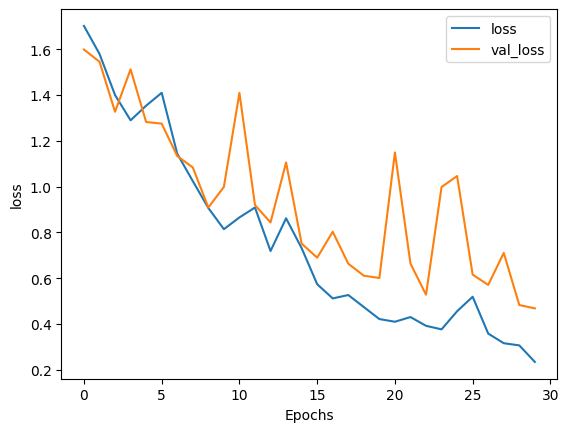

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Predict

In [ ]:
validation_sentences[0]

'hobbit picture  four years away  lord rings director peter jackson said will four years starts work film version hobbit.  oscar winner said visit sydney  desire  make  not lengthy negotiations.  think s gonna lot lawyers sitting room trying thrash deal will ever happen   said new zealander. rights jrr tolkien s book split two major film studios. jackson  currently filming remake hollywood classic king kong  said thought sale mgm studios sony corporation cast uncertainty project. 43-year-old australian city visit lord rings exhibition  attracted 140 000 visitors since opened december.  film-maker recently sued film company new line cinema undisclosed damages alleged withheld profits lost revenue first part middle earth trilogy. fellowship ring 2001 went make worldwide profits $291 million (£152 million). jackson thought secured lucrative film directing deal history remake king kong  currently production wellington. picture  stars naomi watts oscar winner adrien brody  due released dece

In [ ]:
validation_labels[0]

'entertainment'

In [ ]:
validation_label_seq[0]

array([5])

In [ ]:
validation_padded[0]

array([364,   1,   3,  10,   1, 317,   1,   1,   2, 528,   1,  18, 328,
        28,   1,   1, 326,   1,   1, 891,   1,   1,   1,   3, 301, 353,
         1,   1, 508,   1,   1,   1, 569,   1,   7, 109, 642, 558,   1,
       276,   1,   1,   1,   1,  37,   1,  76,   1, 289,  28,   1, 505,
         1,  28,  51,  10, 222,   1,   1,   1,   1,   1, 628, 268,   1,
        16,  80,   1,   1,   1,   1,   1, 499, 311,  26,   1, 628,   1,
        72,   1,  72,   1, 301,   1,   1,  28,   1, 136, 776,   1,   1,
         1, 326, 455,   1,   1, 681,   1,   1, 674, 903,   1,   1, 271,
       422, 289,   1,   8,   1, 202,  28, 493,   1,   1, 151,  23, 786,
       528,   1,   1], dtype=int32)

In [ ]:
validation_label_seq[0]

array([5])

In [ ]:
arr = validation_padded[0]

In [ ]:
reshaped_arr = arr.reshape((1, 120))

In [ ]:
reshaped_arr.shape

(1, 120)

In [ ]:
result = model.predict(reshaped_arr)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


In [ ]:
np.argmax(result)

5

# Predict from raw text

In [ ]:
text = ["hobbit picture  four years away  lord rings director peter jackson said will four years starts work film version hobbit.  oscar winner said visit sydney  desire  make  not lengthy negotiations.  think s gonna lot lawyers sitting room trying thrash deal will ever happen   said new zealander. rights jrr tolkien s book split two major film studios. jackson  currently filming remake hollywood classic king kong  said thought sale mgm studios sony corporation cast uncertainty project. 43-year-old australian city visit lord rings exhibition  attracted 140 000 visitors since opened december.  film-maker recently sued film company new line cinema undisclosed damages alleged withheld profits lost revenue first part middle earth trilogy. fellowship ring 2001 went make worldwide profits $291 million (£152 million). jackson thought secured lucrative film directing deal history remake king kong  currently production wellington. picture  stars naomi watts oscar winner adrien brody  due released december. jackson also committed making film version lovely bones  based best-selling book alice sebold."]

In [ ]:
def inference(text):
  inference_sequences = tokenizer.texts_to_sequences(text)
  inference_padded = pad_sequences(inference_sequences, padding=padding_type, maxlen=max_length)
  return inference_padded

In [ ]:
inference(text)

array([[364,   1,   3,  10,   1, 317,   1,   1,   2, 528,   1,  18, 328,
         28,   1,   1, 326,   1,   1, 891,   1,   1,   1,   3, 301, 353,
          1,   1, 508,   1,   1,   1, 569,   1,   7, 109, 642, 558,   1,
        276,   1,   1,   1,   1,  37,   1,  76,   1, 289,  28,   1, 505,
          1,  28,  51,  10, 222,   1,   1,   1,   1,   1, 628, 268,   1,
         16,  80,   1,   1,   1,   1,   1, 499, 311,  26,   1, 628,   1,
         72,   1,  72,   1, 301,   1,   1,  28,   1, 136, 776,   1,   1,
          1, 326, 455,   1,   1, 681,   1,   1, 674, 903,   1,   1, 271,
        422, 289,   1,   8,   1, 202,  28, 493,   1,   1, 151,  23, 786,
        528,   1,   1]], dtype=int32)

In [ ]:
result = model.predict(inference(text))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


In [ ]:
np.argmax(result)

5